## 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

## 2. Load dataset

In [2]:
train_df = pd.read_csv('/Users/neverintjoker/Downloads/Dataset/KDD/KDDTrain+.csv', header=0)
test_df = pd.read_csv('/Users/neverintjoker/Downloads/Dataset/KDD/KDDTest+.csv', header=0)

## 3. Preprocess (encode categorical, scale numerical)

In [3]:
categorical_cols = ['protocol_type', 'service', 'flag']
full_df = pd.concat([train_df, test_df], ignore_index=True)

for col in categorical_cols:
    le = LabelEncoder()
    full_df[col] = le.fit_transform(full_df[col])

train_processed = full_df.iloc[:len(train_df), :]
test_processed = full_df.iloc[len(train_df):, :]

X_train = train_processed.drop(columns=train_processed.columns[-1])
X_test = test_processed.drop(columns=test_processed.columns[-1])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4. Choose optimal number of clusters using Elbow method

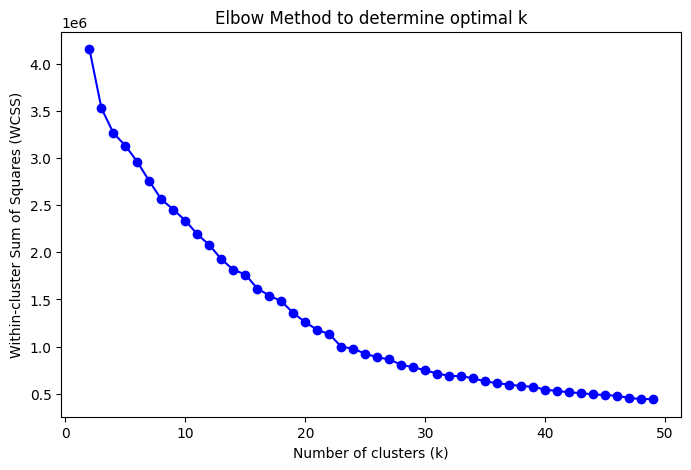

In [12]:
# Elbow Method to find optimal k
wcss = []
k_range = range(2, 50)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_train_scaled)
    wcss.append(km.inertia_)

# Plot to visually determine optimal k
plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.title('Elbow Method to determine optimal k')
plt.show()

In [ ]:
silhouette_scores_train = []
silhouette_scores_test = []
k_values = range(10, 11)

best_k = 10
best_silhouette_test = -1  # Initial value for comparison

for k in k_values:
    # Train KMeans model
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_scaled)

    # Predict clusters
    train_clusters = kmeans.predict(X_train_scaled)
    test_clusters = kmeans.predict(X_test_scaled)

    # Compute silhouette scores
    silhouette_train = silhouette_score(X_train_scaled, train_clusters)
    silhouette_test = silhouette_score(X_test_scaled, test_clusters)

    silhouette_scores_train.append(silhouette_train)
    silhouette_scores_test.append(silhouette_test)

    print(f"k={k}: Train Silhouette={silhouette_train:.4f}, Test Silhouette={silhouette_test:.4f}")

    # Check if this is the best silhouette score on test data
    if silhouette_test > best_silhouette_test:
        best_silhouette_test = silhouette_test
        best_k = k

# After loop ends:
print("\n========================================")
print(f"🌟 Best k found: {best_k} with Test Silhouette Score: {best_silhouette_test:.4f}")

# Optional: visualize the Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores_train, label='Train Silhouette', marker='o')
plt.plot(k_values, silhouette_scores_test, label='Test Silhouette', marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Values of k (10-50)')
plt.legend()
plt.grid(True)
plt.show()

## 5. Train the KMeans model -> 10

In [4]:
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
kmeans.fit(X_train_scaled)

train_clusters = kmeans.predict(X_train_scaled)
test_clusters = kmeans.predict(X_test_scaled)

## 6. Evaluate using Silhouette score

In [15]:
# Silhouette Score Evaluation
train_silhouette = silhouette_score(X_train_scaled, train_clusters)
test_silhouette = silhouette_score(X_test_scaled, test_clusters)

print(f'Train Silhouette Score: {train_silhouette:.4f}')
print(f'Test Silhouette Score: {test_silhouette:.4f}')

Train Silhouette Score: 0.4495
Test Silhouette Score: 0.4501


## 7. Optional visualization with PCA

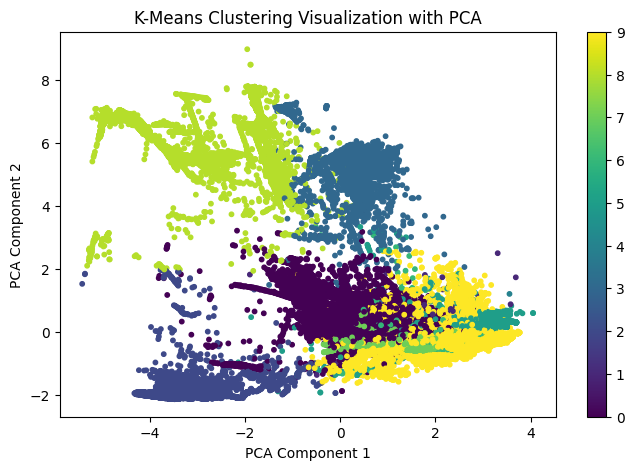

In [14]:
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(8, 5))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_clusters, cmap='viridis', s=10)
plt.title('K-Means Clustering Visualization with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()

## 8. Append Cluster Labels to Original Data

In [5]:
# Append cluster labels as new feature
train_with_cluster = X_train.copy()
test_with_cluster = X_test.copy()

train_with_cluster['cluster'] = train_clusters
test_with_cluster['cluster'] = test_clusters

# True labels
y_train = train_processed.iloc[:, -1]
y_test = test_processed.iloc[:, -1]

## 8.5 Best Parameter for Random Forest

In [ ]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='f1_macro', cv=5)
grid.fit(train_with_cluster, y_train)

print(grid.best_params_)
y_pred_optimized = grid.predict(test_with_cluster)
print(classification_report(y_test, y_pred_optimized))

## 9. Train a Random Forest Classifier

In [6]:
# Apply SMOTE to balance training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(train_with_cluster, y_train)

# Train Random Forest clearly on SMOTE-balanced data
rf_smote = RandomForestClassifier(n_estimators=200, min_samples_split= 2, random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)

# Predictions on original datasets (no changes here)
y_pred_train_smote = rf_smote.predict(train_with_cluster)
y_pred_test_smote = rf_smote.predict(test_with_cluster)

## 10. Evaluate the Model

=== SMOTE Random Forest Training Evaluation ===
              precision    recall  f1-score   support

     anomaly       1.00      1.00      1.00     58630
      normal       1.00      1.00      1.00     67343

    accuracy                           1.00    125973
   macro avg       1.00      1.00      1.00    125973
weighted avg       1.00      1.00      1.00    125973

=== SMOTE Random Forest Test Evaluation ===
              precision    recall  f1-score   support

     anomaly       0.97      0.63      0.76     12833
      normal       0.67      0.97      0.79      9711

    accuracy                           0.78     22544
   macro avg       0.82      0.80      0.78     22544
weighted avg       0.84      0.78      0.78     22544



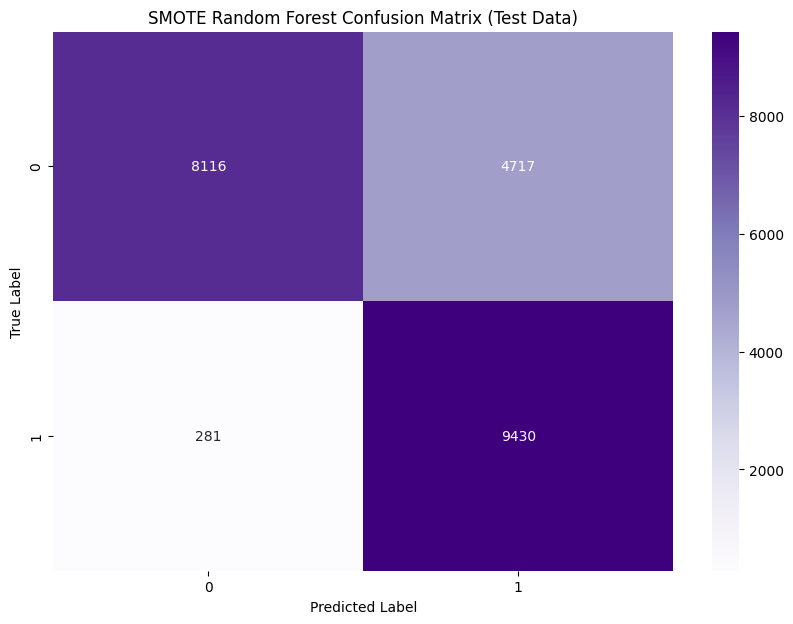

In [7]:
# Evaluate clearly
print("=== SMOTE Random Forest Training Evaluation ===")
print(classification_report(y_train, y_pred_train_smote, zero_division=0))

print("=== SMOTE Random Forest Test Evaluation ===")
print(classification_report(y_test, y_pred_test_smote, zero_division=0))

# Confusion Matrix Visualization
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred_test_smote), annot=True, fmt='d', cmap='Purples')
plt.title("SMOTE Random Forest Confusion Matrix (Test Data)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()